# Digital homodyne detection

In [1]:
import matplotlib.pyplot as plt
import cvxpy as cp
import numpy as np

from qutip import *

from scipy.special import factorial, eval_hermite
from scipy.integrate import quad
from joblib import Parallel, delayed

## Define basic operators

In [2]:
N=15

idc = qeye(N)
ida = qeye(2)

a  = tensor(destroy(N), ida)
sm = tensor(idc, destroy(2)) # note that this is not qutip's sigmam() definition

sx = tensor(idc, sigmax())
sy = tensor(idc, sigmay())
sz = tensor(idc, sigmaz())

proj0 = tensor(idc, basis(2,0).proj())
proj1 = tensor(idc, basis(2,1).proj())

## Define unitaries

In [3]:
def rotateX(theta):
    op = (-1j) * (theta/2) * sx
    return op.expm()

def rotateY(theta):
    op = (-1j) * (theta/2) * sy
    return op.expm()

def rotateXY(theta,rotangl):
    op = (-1j) * (theta/2) * (np.cos(rotangl)* sx + np.sin(rotangl)* sy)
    return op.expm()

def H_int(g, dt):
    Hint = (-1j) * g*np.sqrt(dt) * (a.dag() * sm + a * sm.dag())
    return Hint.expm()

def U_gint(gint):
    Hint = (-1j) * gint* (a.dag() * sm + a * sm.dag())
    return Hint.expm()

## Parameters and initial state

(0.3535533905932738, 0.7071067811865476)

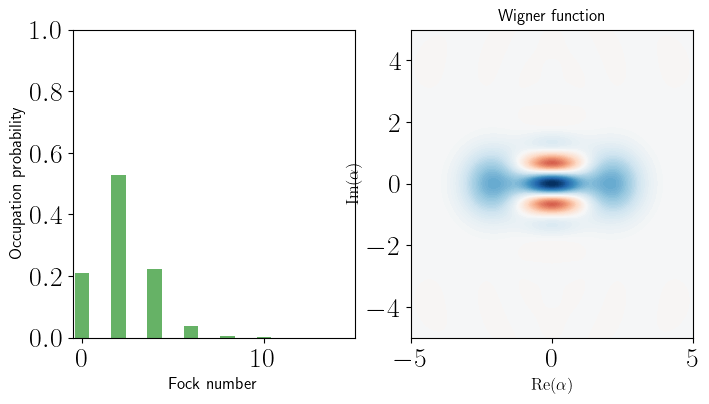

In [22]:
# number of qubit measurements per trajectory
Nmeas = 100

# number of trajectories
Ntrajs = 1000

# interaction strength
g = 0.5
delta_t = 0.5

gamma = g**2

# effective interaction strength
gint = np.sqrt(gamma*delta_t)
# initialize state



#initial_cavity = (fock(N,0) + fock(N,4)).unit()
alphain = 1.5
initial_cavity = (coherent(N, alphain) + coherent(N,-alphain)).unit()

#initial_cavity = coherent(N,alphain)

psi0 = tensor(initial_cavity, basis(2,0))


plot_wigner_fock_distribution(initial_cavity, alpha_max=5)

gint, 2*gint

## Implements homodyne detection

### Homodyne settings

In [23]:
# homodyne angles
nangles = 10 # number of angles
thetas = np.linspace(0,np.pi, nangles) # list of all angles

# histogram parameters
Nbins = 30 # number of histogram bins
L = 5  # bin edge limit
dx =  2*L/Nbins # bin width

### Filter function

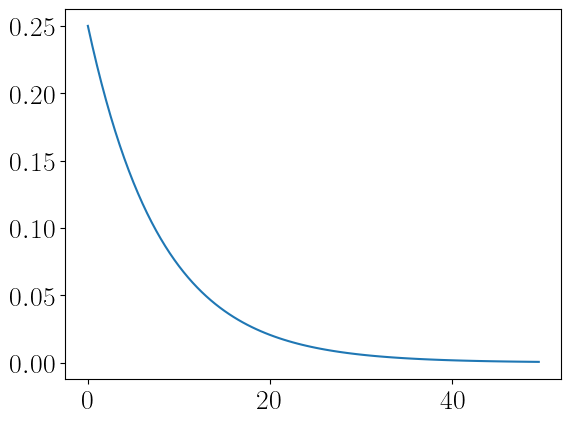

In [24]:
# weight measurement results with exponential filter
nsteps = np.linspace(0,Nmeas-1,Nmeas)

weights=(gint/np.sqrt(2))*np.exp(-nsteps*(gint**2/2))
#weights /= sum(weights**2)

#weights = weights / np.trapz(weights**2, dx=delta_t)

plt.plot(delta_t*nsteps, weights)

### Simulate homodyne

In [25]:
# interaction unitary
#U_int = H_int(g, delta_t)

U_int = U_gint(gint)

# get measurement histogram for one homodyne angle
def get_hist(rotangl):
    
    ### simulate tomography ###
    
    qbrotmat = rotateXY(np.pi/2,rotangl) # qb rotation applied prior to qb measurement, defines measured homodyne quadrature
    
    qbfeedback = rotateX(np.pi) # this pulse will reset the qubit if found in the excited state
    quadmeashom = []

    for j in range(Ntrajs):
        xrnd = np.random.rand(Nmeas)
    
        results = []
        psi = psi0

        for i in range(Nmeas):
            psi = qbrotmat * (U_int * psi)
            prob = expect(proj0,psi)

            if prob>xrnd[i]:
                # measured g
                results.append(-1)
                psi = (proj0 * psi).unit()
            else:
                results.append(1)
                # measured e
                psi = (proj1 * psi).unit()
                # go back to g
                psi = qbfeedback * psi
    
        quadmeashom.append(np.sum(results*weights))
    
    
    ### create histogram ###    
    hist, bins, _ = plt.hist(quadmeashom,Nbins,[-L,L], density=True, alpha=0.5)
    #print(psi.ptrace(0))
    return hist   

In [26]:
# get histograms for all angles in parallell
# NOTE: multiprocessing backend can give duplicate measurement results. loky should be ok though
# https://joblib.readthedocs.io/en/latest/auto_examples/parallel_random_state.html

b_all = Parallel(n_jobs=-1, verbose=5, backend="loky")(delayed(get_hist)(rotangle) for rotangle in thetas)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:   29.1s remaining:   43.6s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   29.6s remaining:   12.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   30.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   30.3s finished


# Tomography

### Prepare data and operators

In [27]:
# Load homodyne data into vector $\vec b$
b = np.concatenate([array for array in b_all])

### Define the harmonic oscillator wavefunction
#To create homodyne POVM operators.

def wavefunction(x,n):
    const = 1/(np.sqrt(2**n * factorial(n)) * (np.pi)**0.25 )
    rest = const* np.exp(-x**2/2)
    return float(rest*eval_hermite(n,x))

### Construct operators

def get_Pis(theta, i):
    Pi = np.zeros((N,N),dtype=np.complex128)
    for m in range(N):
        wave_m = lambda x : wavefunction(x, m)
        for n in range(N):
            wave_n = lambda x: wavefunction(x, n)            
            func = lambda x: wave_m(x)*wave_n(x)
            Pi[n,m] = quad(func, -L + i*dx, -L + (i+1)*dx)[0]*np.exp(-1j*(n-m)*theta)
            
    return Pi*2 #

Pis = Parallel(n_jobs=16, verbose=5, backend="multiprocessing")(delayed(get_Pis)(theta,i) for theta in thetas for i in range(Nbins))

#The list `basis_dms` contains all $\Omega_k$
# construct vectors
basis_vectors = []
for i in range(N):
    vector = fock(N, i)
    basis_vectors.append(np.real(vector.full()))
    
# construct operators
basis_dms = []
for vector1 in basis_vectors:
    for vector2 in basis_vectors:
        dm = np.outer(vector1, vector2)
        basis_dms.append(dm)

### Construct the matrix A in $A\vec\rho=\vec b$
#From `Pis` and `basis_dms`.

def func(index, a):
    return np.trace(Pis[index[0]] @ basis_dms[index[1]])

A = np.zeros((len(Pis), N*N), dtype=np.complex64)
A_p = Parallel(n_jobs=16, verbose=5, backend="multiprocessing")(delayed(func)(idx,a) for idx, a in np.ndenumerate(A))

A = np.reshape(A_p, (len(Pis), N*N))

[Parallel(n_jobs=16)]: Using backend MultiprocessingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  48 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=16)]: Using backend MultiprocessingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  48 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 512 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 8160 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 66296 tasks      | elapsed:    1.0s
[Parallel(n_jobs=16)]: Done 67500 out of 67500 | elapsed:    1.0s finished


### Convex optimization

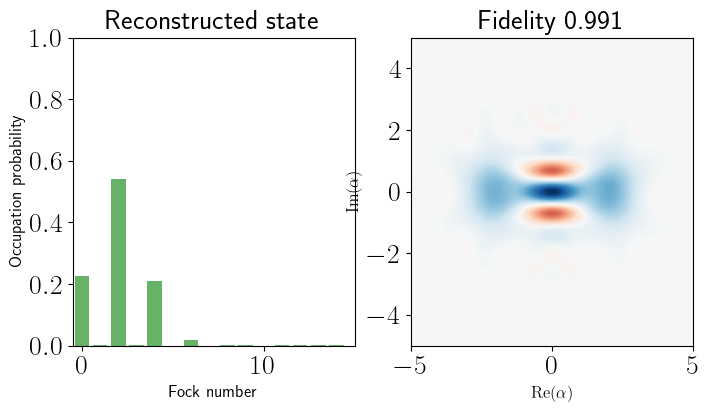

In [28]:
# Define the unknown state as a $N\times N$ Hermitian matrix

X = cp.Variable((N,N), hermitian=True)

#Set the cost function to $\|A\vec\rho - \vec b\|_2$ where the vectorized state is given by `cp.vec(X)`.

cost = cp.norm(A @ cp.vec(X) - b, 2) 

#Set the trace constraint and positive-semidefinite constraint
constraints = [cp.trace(X) == 1, X >> 0 ]

#Set up and solve the problem!

prob = cp.Problem(cp.Minimize(cost), constraints)
prob.solve(verbose=False)

# Assign the optimized state X to a Qobj.
reconstructed_rho = Qobj(X.value)

### Visualize results

#Plot the reconstructed state 
alpha_max = 5
fig, ax = plot_wigner_fock_distribution(reconstructed_rho, alpha_max=5)
ax[0].set_title("Reconstructed state")

f=fidelity(reconstructed_rho, initial_cavity)**2
ax[1].set_title("Fidelity %.3f"%(f));

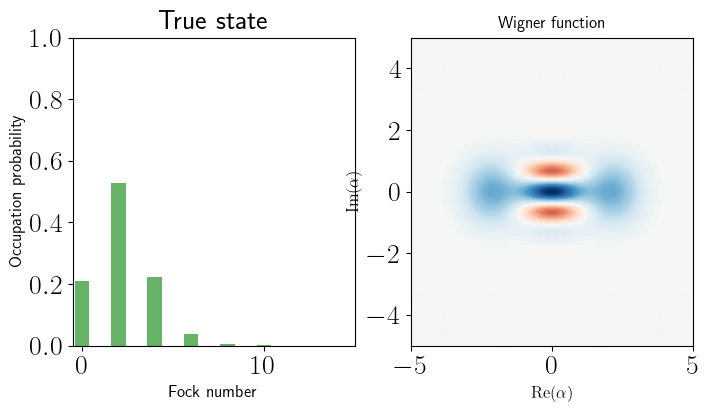

In [29]:
fig, ax = plot_wigner_fock_distribution(initial_cavity, alpha_max=5);
ax[0].set_title("True state");
